# Setup

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# import tensorflow as tf

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings('always')

In [2]:
np.random.seed(42)

In [3]:
def plot_svm():
    # https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
    # getting the decision function
    plt.figure(figsize=(10, 5))
    decision_function = svc.decision_function(X)
    support_vector_indices = np.where((2 * y - 1) * decision_function <= 1)[0]
    support_vectors = X[support_vector_indices]

    # plot observations
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # creating the grid to evaluate the model
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot decision boundaries and margins
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    # plot support vectors
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')

    plt.title("Linear SVM (Hard Margin Classification)")
    plt.tight_layout()
    plt.show()

In [25]:
# https://github.com/python-engineer/MLfromscratch/blob/master/mlfromscratch/svm.py
# https://pub.towardsai.net/supporting-the-math-behind-supporting-vector-machines-d46e94b23b9d
def visualize_svm(w, b):
    def get_hyperplane_value(x, w, b, offset):
        return -(w[0] * x + b + offset) / w[1]
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    plt.scatter(X[:, 0], X[:,1], c=y, cmap=plt.cm.Paired)

    x0_1 = np.amin(X[:, 0])
    x0_2 = np.amax(X[:, 0])

    x1_1 = get_hyperplane_value(x0_1, w, b, 0)
    x1_2 = get_hyperplane_value(x0_2, w, b, 0)

    x1_1_n = get_hyperplane_value(x0_1, w, b, -1)
    x1_2_n = get_hyperplane_value(x0_2, w, b, -1)

    x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
    x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], 'y')
    ax.plot([x0_1, x0_2], [x1_1_n, x1_2_n], 'k--', alpha=0.5)
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], 'k--', alpha=0.5)

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])
    
    plt.title("My implementation of Linear SVM (Hard Margin Classification)")
    plt.tight_layout()

    plt.show()

In [5]:
# dataset: https://www.kaggle.com/ronitf/heart-disease-uci
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
df.target.unique()

array([1, 0], dtype=int64)

In [7]:
# NOTE: SVM requires negative labels to be -1
df['target'] = np.where(df['target'].values == 0, -1, 1)

In [8]:
df.target.unique()

array([ 1, -1])

In [9]:
X = df.drop(columns=['target'])
y = df['target'].copy()
X.shape, y.shape

((303, 13), (303,))

In [10]:
y = y.values.reshape(-1, 1)
y.shape

(303, 1)

In [11]:
from sklearn.datasets import make_blobs 

# # generating a dataset
X, y = make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=42)
X.shape, y.shape

((50, 2), (50,))

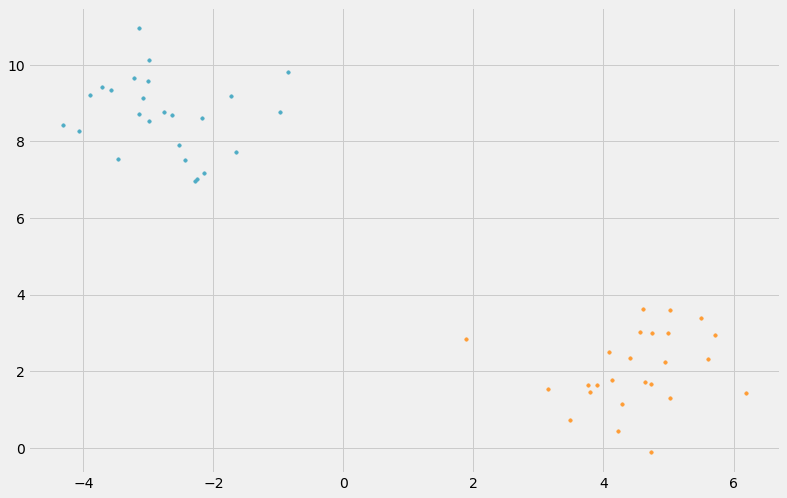

In [12]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_plusplus.html#sphx-glr-auto-examples-cluster-plot-kmeans-plusplus-py
colors = ['#4EACC5', '#FF9C34']

for idx, col in zip([0, 1], colors):
    cluster_data = (y.reshape(-1) == idx)
    plt.scatter(X[cluster_data, 0], X[cluster_data, 1],
                c=col, marker='.', s=50)

# Linear SVM

**Cost function** <br>
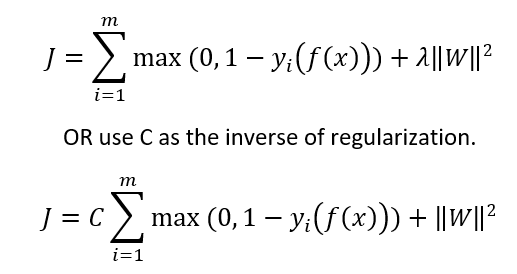

**Derivatives** <br>
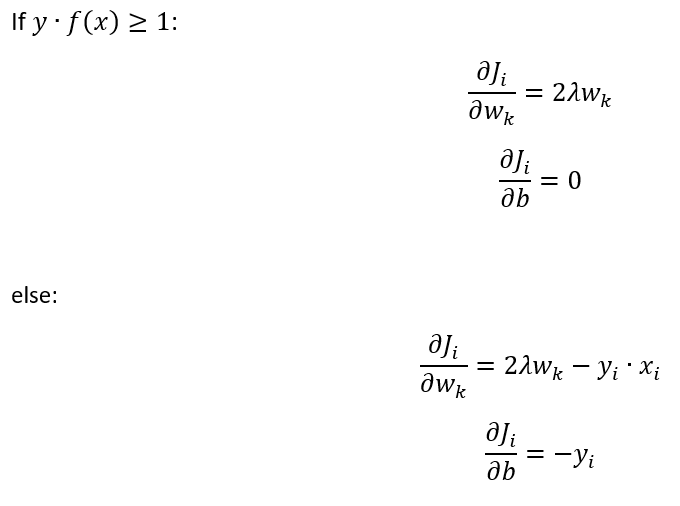

In [13]:
class LinearSVM:
    def __init__(self, lambda_param=0.01):
        self.params = {}
        self.lambda_param = lambda_param
        
    def init_params(self, X):
        """Randomly initializing parameters"""
        n_features = X.shape[1]  # number of features
        # the matrix for slope coefficients
        self.params['coef'] = np.zeros(n_features)
        # the y-intercept
        self.params['intercept'] = np.array(0.)
        if self.verbose:
            print("[INFO] Initialized parameters.")
            print(f"Shape of coefficient matrix: {self.params['coef'].shape}")
            print(f"Shape of intercept matrix: {self.params['intercept'].shape}")
            
    def fit(self, X, y, learning_rate=0.001, iterations=1000, skip_loss=1, verbose=0):
        # set verbose to 1 to see the entire training progress
        self.verbose = verbose
        
        if isinstance(X, pd.DataFrame):
            # convert Dataframe to numpy for faster computations 
            X = X.values
            
        # initialize parameters
        self.init_params(X)
        
        # NOTE: SVM requires negative labels to be -1
        y = np.where(y <= 0, -1, 1)
        w = self.params['coef']
        b = self.params['intercept']
        lambd = self.lambda_param
    
        if verbose:
            print("[INFO] Training ...")
        for i in range(1, iterations + 1): 
            for idx, x_i in enumerate(X):
                decision = np.dot(x_i, w) + b
                condition = y[idx] * decision >= 1
                if condition:
                    # Not misclassified
                    if not skip_loss:
                        loss = 1 / 2 * np.sum(w ** 2)
                    derivative = 2 * lambd * w
                    w -= (learning_rate * derivative)
                else:
                    # misclassified
                    if not skip_loss:
                        hinge_loss = 1 - y[idx] * decision
                        loss = hinge_loss + 1 / 2 * np.sum(w ** 2)
                    derivative = 2 * lambd * w - np.dot(x_i, y[idx])
                    w -= (learning_rate * derivative)
                    b -= (learning_rate * - y[idx])
            
            if verbose and (i == 1 or i % 100 == 0):
                print(f"\nIteration {i}/{iterations}")
                print("--" * 12)
                if not skip_loss:
                    print(f"Loss: {loss}")
                print(f"Coefficient:\n{w}")
                print(f"Intercept:\n{b}")
        
        self.params['coef'] = w
        self.params['intercept'] = b
                
    def predict(self, X):
        decision = np.dot(X, self.params['coef']) + self.params['intercept']
        return np.sign(decision)
    
    def predict_score(self, X, y):
        from sklearn.metrics import accuracy_score
        y = np.where(y <= 0, -1, 1)
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [14]:
%%time
my_lin_SVM = LinearSVM()
my_lin_SVM.fit(X, y, verbose=0)

Wall time: 310 ms


In [15]:
my_lin_SVM.params['coef'].shape, my_lin_SVM.params['intercept'].shape

((2,), ())

In [16]:
my_lin_SVM.params

{'coef': array([ 0.52735146, -0.08786235]), 'intercept': array(0.263)}

In [17]:
my_lin_SVM.predict_score(X, y)

1.0

In [18]:
idx = np.random.randint(len(X))
print(f"Predicted = {my_lin_SVM.predict(X[idx])}")
print(f"Actual = {y[idx]}")

Predicted = 1.0
Actual = 1


# Visualizations

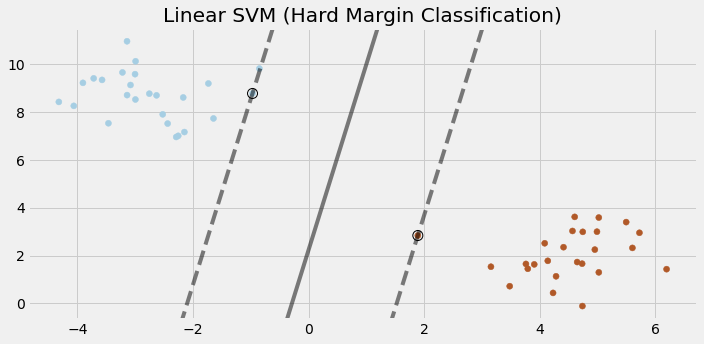

In [19]:
# fit the model with hard margin (Large C parameter for no regularization)
svc = LinearSVC(loss="hinge", C=1000)
svc.fit(X, y)

# sklearn implementation visualization
plot_svm()

In [20]:
svc.coef_, svc.intercept_

(array([[ 0.55180539, -0.07105445]]), array([0.15905885]))

In [21]:
my_lin_SVM.params

{'coef': array([ 0.52735146, -0.08786235]), 'intercept': array(0.263)}

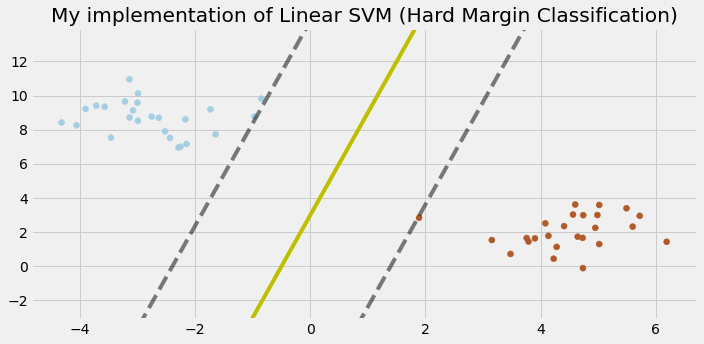

In [26]:
w, b = my_lin_SVM.params['coef'], my_lin_SVM.params['intercept']
visualize_svm(w, b)